In [74]:
import os
import logging

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
import xml.etree.ElementTree as ET
from xml.dom import minidom
from xml.dom.minidom import parse, parseString
import requests
import tarfile
import jsonlines
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
import PyPDF2
from PyPDF2 import PdfFileReader
from matplotlib.patches import  Rectangle
from PIL import ImageFont, ImageDraw
import pdf2image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Conv2D
import json

In [75]:
data_path = 'D:/PubTables-1M-Structure_Images_Test/'
source_xml_path = 'D:/PubTables-1M-Structure_Annotations_Test/'
source_word_path ='D:/PubTables-1M-Structure_Table_Words/'

In [76]:
file_list = []
i = 0
for file in os.listdir(data_path):
    if file.endswith(".jpg"):
        file_list.append(file)
        i = i +1 
        if i >  6000:
            break
# file_list
test_file_list = file_list
test_file_list

['PMC1064078_table_0.jpg',
 'PMC1064078_table_2.jpg',
 'PMC1064078_table_3.jpg',
 'PMC1064078_table_4.jpg',
 'PMC1064078_table_5.jpg',
 'PMC1064078_table_6.jpg',
 'PMC1064082_table_0.jpg',
 'PMC1064082_table_1.jpg',
 'PMC1064098_table_0.jpg',
 'PMC1064098_table_1.jpg',
 'PMC1064098_table_2.jpg',
 'PMC1064098_table_3.jpg',
 'PMC1064109_table_0.jpg',
 'PMC1064109_table_1.jpg',
 'PMC1064111_table_0.jpg',
 'PMC1064135_table_0.jpg',
 'PMC1064135_table_1.jpg',
 'PMC1064135_table_2.jpg',
 'PMC1064879_table_0.jpg',
 'PMC1065057_table_0.jpg',
 'PMC1065063_table_0.jpg',
 'PMC1065063_table_1.jpg',
 'PMC1065063_table_2.jpg',
 'PMC1065063_table_3.jpg',
 'PMC1065063_table_4.jpg',
 'PMC1065063_table_5.jpg',
 'PMC1065107_table_0.jpg',
 'PMC1065107_table_1.jpg',
 'PMC1065107_table_2.jpg',
 'PMC1065333_table_0.jpg',
 'PMC1065333_table_1.jpg',
 'PMC1079800_table_0.jpg',
 'PMC1079800_table_1.jpg',
 'PMC1079800_table_2.jpg',
 'PMC1079800_table_3.jpg',
 'PMC1079800_table_4.jpg',
 'PMC1079832_table_0.jpg',
 

In [77]:
def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    size = root.find('size')

    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Create grayscale image array
    col_mask = np.zeros((height, width), dtype=np.int32)
    table_mask = np.zeros((height, width), dtype = np.int32)

    objs  = root.findall('object')
    # col 
    col_bbox_list = []
    col_num = 0 
    for obj in objs:
        name = obj.find('name').text
        if name == 'table column':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]
            col_bbox_list.append(bbox)
            col_num = col_num +1 
    # row 
    row_bbox_list  = []
    row_num = 0
    for obj in objs:
        name = obj.find('name').text
        if name == 'table row':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]
            row_bbox_list.append(bbox)
            row_num = row_num +1 
    return  row_bbox_list , col_bbox_list, row_num ,  col_num

In [78]:
def crop_table(img_path , file_xml_path):
    image = Image.open(img_path)
    image_np = np.array(image)
    xlm_file_name = file_name + '.xml'
    file_xml_path = source_xml_path +  xlm_file_name 
    tree = ET.parse(file_xml_path)
    root = tree.getroot()

    objs  = root.findall('object')
    for obj in objs:
        name = obj.find('name').text
        if name == 'table':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]
    table_image = image.crop((xmin, ymin, xmax, ymax))
    table_image_np = np.array(table_image)
    return table_image_np

In [79]:
def get_offset(file_xml_path , word_json_path):
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs:
        name = obj.find('name').text
        if name == 'table':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]


            offset_x_axis = xmin
            offset_y_axis = ymin
    return offset_x_axis, offset_y_axis

In [80]:
def get_table_spaning_cell(file_xml_path , word_json_path):
    table_spaning_cell_list = []
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs: 
        name = obj.find('name').text
        if (name == 'table spanning cell') : #| (name =='table column header' ) :
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text) +1 )
            ymin = int(float(bndbox.find('ymin').text) +1)
            xmax = int(float(bndbox.find('xmax').text) +1)
            ymax = int(float(bndbox.find('ymax').text) +1)
            bbox = [xmin, ymin , xmax, ymax]
            table_spaning_cell_list.append(bbox)
    # print(table_spaning_cell_list)
    return table_spaning_cell_list

In [81]:
def show_img(img_np):
    plt.imshow(img_np)
    plt.show()
def show_spaning_cell(img_np, table_spaning_cell):
    for box in table_spaning_cell:
        x1 , y1 , x2 , y2 = box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img_np
def show_img_box_raw(img_np, box_list_row, box_list_col,table_spaning_cell = []):
    img_raw = img_np.copy()
    img_span_cell = show_spaning_cell(img_raw, table_spaning_cell)
    for box in box_list_row:
        x1 , y1 , x2 , y2 = box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for box in box_list_col:
        x1 , y1 , x2 , y2 = box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
    fig, ax = plt.subplots(1, 2, figsize=(25, 25))
    ax[0].imshow(img_raw)
    ax[1].imshow(img_np)

In [82]:
def get_col_raw(file_xml_path , col_bbox_list , word_json_path):
    element_bbox_list = {}
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs:
        name = obj.find('name').text
        if name == 'table':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]


            offset_x_axis = xmin
            offset_y_axis = ymin
    table_image = image.crop((xmin, ymin, xmax, ymax))
    
       

In [83]:
def table_row(file_xml_path , word_json_path):
    table_row_list = []
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs: 
        name = obj.find('name').text
        if (name == 'table row') :
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text) +1 )
            ymin = int(float(bndbox.find('ymin').text) +1)
            xmax = int(float(bndbox.find('xmax').text) +1)
            ymax = int(float(bndbox.find('ymax').text) +1)
            bbox = [xmin, ymin , xmax, ymax]
            table_row_list.append(bbox)
    # print(table_row_list)
    return table_row_list
def table_col(file_xml_path , word_json_path):
    table_col_list = []
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs: 
        name = obj.find('name').text
        if (name == 'table column') :
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text) +1 )
            ymin = int(float(bndbox.find('ymin').text) +1)
            xmax = int(float(bndbox.find('xmax').text) +1)
            ymax = int(float(bndbox.find('ymax').text) +1)
            bbox = [xmin, ymin , xmax, ymax]
            table_col_list.append(bbox)
    # print(table_row_list)
    return table_col_list
def table_header(file_xml_path , word_json_path):
    table_header_list = []
    tree = ET.parse(file_xml_path)
    root = tree.getroot()
    objs  = root.findall('object')
    for obj in objs: 
        name = obj.find('name').text
        if (name == 'table column header') :
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text) +1 )
            ymin = int(float(bndbox.find('ymin').text) +1)
            xmax = int(float(bndbox.find('xmax').text) +1)
            ymax = int(float(bndbox.find('ymax').text) +1)
            bbox = [xmin, ymin , xmax, ymax]
            table_header_list.append(bbox)
    # print(table_row_list)
    return table_header_list  

In [84]:
def check_box_in_box(box_1, box_2, box_span):
    check_1 = 0
    check_2 = 0 
    x1_1, y1_1, x2_1, y2_1 = box_1
    x1_2, y1_2, x2_2, y2_2 = box_2
    x1_span, y1_span, x2_span, y2_span = box_span

    if x1_1 >= x1_span - 2 and x2_1 <= x2_span + 2 and y1_1 >= y1_span - 2 and y2_1 <= y2_span + 2:
        check_1 = 1 
    if x1_2 >= x1_span - 2 and x2_2 <= x2_span + 2 and y1_2 >= y1_span - 2 and y2_2 <= y2_span + 2:
        check_2 = 1
    if (check_1 == 1 and check_2 == 1):
        return True
    else:
        return False

In [85]:
def get_matrix_col_merge(table_row_list, table_col_list,table_spaning_cell):
    row_num = len(table_row_list)
    row_col = len(table_col_list)
    # print(row_num, row_col)
    matrix_row = np.zeros(shape=(row_num  , row_col  ), dtype= int)
    matrix_col = np.zeros(shape=(row_num  , row_col  ), dtype= int)

    cell = []
    cell_dcit_row ={i: [] for i in range(row_num)}
    for idx, row_box in enumerate(table_row_list):
        # print(idx)
        x1_row, y1_row, x2_row, y2_row = row_box
        for col_box in table_col_list:
            x1_col, y1_col, x2_col, y2_col = col_box
            cell_dcit_row[idx].append([x1_col, y1_row, x2_col, y2_row])
            cell.append([x1_col, y1_row, x2_col, y2_row])
    
    for idx in range(row_num): # hang 
        sub_cell_row = cell_dcit_row[idx]
        for i in range(len(sub_cell_row) - 1 ):# cot 
            box_1 = sub_cell_row[i]
            box_2 = sub_cell_row[i + 1]
            for box_span in table_spaning_cell:
                check = check_box_in_box(box_1, box_2, box_span)
                if (check):
                    matrix_row[idx,i+1] = 1 
    return matrix_row[:,1:]

In [86]:
def get_matrix_row_merge(table_row_list, table_col_list,table_spaning_cell):
    row_num = len(table_row_list)
    col_num = len(table_col_list)
    # print(row_num, col_num)
    matrix_row = np.zeros(shape=(row_num  , col_num  ), dtype= int)
    matrix_col = np.zeros(shape=(row_num  , col_num  ), dtype= int)

    cell = []
    cell_dcit_col ={i: [] for i in range(col_num)}
    for idx, col_box in enumerate(table_col_list):
        # print(idx)
        x1_col, y1_col, x2_col, y2_col = col_box
        for row_box in table_row_list:
            x1_row, y1_row, x2_row, y2_row = row_box
            cell_dcit_col[idx].append([x1_col, y1_row, x2_col, y2_row])
            cell.append([x1_col, y1_row, x2_col, y2_row])

    for idx in range(col_num): # cot 
        sub_cell_col = cell_dcit_col[idx]
        for i in range(len(sub_cell_col) - 1 ):# cot 
            box_1 = sub_cell_col[i]
            box_2 = sub_cell_col[i + 1]
            for box_span in table_spaning_cell:
                check = check_box_in_box(box_1, box_2, box_span)
                if (check):
                    matrix_row[i+1,idx] = 1 
    return matrix_row[1:,:]

In [87]:
def get_row_col_reshape(img_path,file_xml_path, word_json_path):
    table_row_list = table_row(file_xml_path, word_json_path)
    table_col_list = table_col(file_xml_path, word_json_path)
    image_crop = crop_table(img_path , file_xml_path)
    X_axis, Y_axis = get_offset(file_xml_path, word_json_path)

    table_row_offset_list = []
    for box in table_row_list :
        x1, y1 , x2, y2 = box
        x1 = x1 - X_axis
        y1 = y1 - Y_axis
        x2 = x2 - X_axis
        y2 = y2 - Y_axis
        table_row_offset_list.append([x1,y1,x2,y2])

    table_col_offset_list = []
    for box in table_col_list :
        x1, y1 , x2, y2 = box
        x1 = x1 - X_axis
        y1 = y1 - Y_axis
        x2 = x2 - X_axis
        y2 = y2 - Y_axis
        table_col_offset_list.append([x1,y1,x2,y2])

    ori_h_table , ori_w_table , c = image_crop.shape
    # print(ori_h_table, ori_w_table)
    scale_x  = 256/ori_w_table
    scale_y  = 256/ori_h_table

    table_col_resize_list = []
    for box in table_col_offset_list :
        x1, y1 , x2, y2 = box
        scaled_x1 = int(x1*scale_x)
        scaled_y1 = int(y1*scale_y)
        scaled_x2 = int(x2*scale_x)
        scaled_y2 = int(y2*scale_y)
        table_col_resize_list.append((scaled_x1, scaled_y1, scaled_x2, scaled_y2))

    table_row_resize_list = []
    for box in table_row_offset_list :
        x1, y1 , x2, y2 = box
        scaled_x1 = int(x1*scale_x)
        scaled_y1 = int(y1*scale_y)
        scaled_x2 = int(x2*scale_x)
        scaled_y2 = int(y2*scale_y)
        table_row_resize_list.append((scaled_x1, scaled_y1, scaled_x2, scaled_y2))


    resize_img = cv2.resize(image_crop, (256,256))
    resize_img = np.array(resize_img, dtype=np.uint8)

    return resize_img, table_row_resize_list, table_col_resize_list

In [88]:
saved_path_matrix_col = 'D:/đề cương/merge/data_2/col/'
saved_path_matrix_row = 'D:/đề cương/merge/data_2/row/'

In [89]:
data_frame_row = {}
data_frame_col = {}
for file_test in test_file_list:
    # file_test = test_file_list[10]
    table_row_list= []
    table_col_list = []
    img_path = data_path + file_test
    # print(file_test)
    file_name = file_test[:-4]
    json_file_name = file_name + '_words.json'
    word_json_path = source_word_path + json_file_name

    xlm_file_name = file_name + '.xml'
    file_xml_path = source_xml_path +  xlm_file_name 

    img_path  = data_path + file_test
    image = Image.open(img_path)
    image_np = np.array(image)


    table_row_list = table_row(file_xml_path, word_json_path)
    table_col_list = table_col(file_xml_path, word_json_path)
    table_header_list = table_header(file_xml_path, word_json_path)
    table_spaning_cell = get_table_spaning_cell(file_xml_path, word_json_path)
    # show_img_box_raw(image_np, table_row_list , table_col_list , table_spaning_cell)
    matrix_col = get_matrix_col_merge(table_row_list, table_col_list,table_spaning_cell)
    matrix_row = get_matrix_row_merge(table_row_list, table_col_list,table_spaning_cell)

    np.save(saved_path_matrix_row + file_name+ '.npy', matrix_row)
    np.save(saved_path_matrix_col + file_name+ '.npy', matrix_col)

    resize_img, table_row_resize_list, table_col_resize_list = get_row_col_reshape(img_path,file_xml_path, word_json_path)

    update_name = file_name
    update_row =[row for row in table_row_resize_list]
    update_col = [col for col in table_col_resize_list]

    update_all_row  = {update_name :[update_row]}
    update_all_col  = {update_name :[update_col]}

    data_frame_row.update(**update_all_row)
    data_frame_col.update(**update_all_col)

# image_crop = crop_table(img_path , file_xml_path)
# X_axis, Y_axis = get_offset(file_xml_path, word_json_path)
# print(X_axis)
# print(Y_axis)
# print(a)
# print(b)

(226, 647, 3)


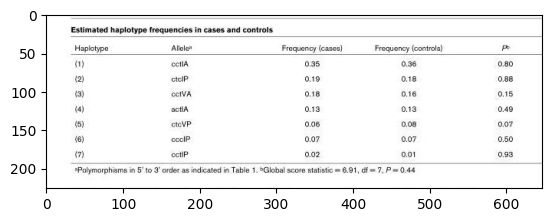

In [90]:
file_name_test = "PMC1064135_table_2"
image = Image.open(data_path + file_name_test + '.jpg')
img_np = np.array(image)
print(img_np.shape)
# image = np.array(image)

a = img_np[36:260, 37:654]
plt.imshow(img_np)
plt.show()

In [91]:
def crop_table(img_path , file_xml_path):
    image = Image.open(img_path)
    image_np = np.array(image)
    xlm_file_name = file_name + '.xml'
    file_xml_path = source_xml_path +  xlm_file_name 
    tree = ET.parse(file_xml_path)
    root = tree.getroot()

    objs  = root.findall('object')
    for obj in objs:
        name = obj.find('name').text
        if name == 'table':
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bbox = [xmin, ymin , xmax, ymax]
    table_image = image_np[ymin :ymax,xmin: xmax]
    table_image_np = np.array(table_image)
    return table_image_np

(190, 610, 3)


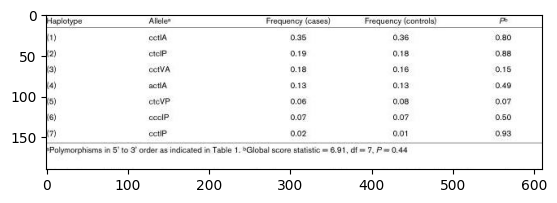

In [92]:
image_path  = data_path + file_name_test + '.jpg'
xml_path = source_xml_path + file_name_test + '.xml'
image_crop = crop_table(image_path , xml_path)
print(image_crop.shape)
plt.imshow(np.array(image_crop))
plt.show()

# test

In [100]:
data_path = 'D:/PubTables-1M-Structure_Images_Test/'
source_xml_path = 'D:/PubTables-1M-Structure_Annotations_Test/'
source_word_path ='D:/PubTables-1M-Structure_Table_Words/'

In [113]:
import pandas as pd
import ast

data_row = pd.read_csv('data_row.csv')
data_col = pd.read_csv('data_col.csv')

In [111]:
def convert_String_to_array(string_array):
    nested_list = ast.literal_eval(string_array)

    return nested_list

In [104]:
def get_cell_list(row, col):
    cell_list = []
    cord_list = []
    for idx_row, box_row in enumerate(row):
        x1_row, y1_row , x2_row, y2_row = box_row
        for idx_col, box_col in enumerate(col):
            x1_col, y1_col, x2_col, y2_col = box_col

            update_cell = [idx_row, idx_col, x1_col, y1_row, x2_col, y2_row]
            update_cord = [idx_row, idx_col]
            cell_list.append(update_cell)
            cord_list.append(update_cord)
    current_len = len(cell_list)
    cell_list = np.array(cell_list)
    # pad = (0, 2500-current_len)
    # cell_list_padded = np.pad(cell_list, (pad, (0,0)), mode= 'constant', constant_values= 0)
    return cell_list, cord_list

In [118]:
def box_feature_map(cell_list):
    new_cell_list = []
    for box in cell_list:
        x_pos, y_pos , x1 , y1 , x2 , y2 = box
        x1 = int((x1*64)/256)
        y1 = int((y1*64)/256)
        x2 = int((x2*64)/256)
        y2 = int((y2*64)/256)
        new_box = [x_pos, y_pos, x1, y1, x2, y2]
        new_cell_list.append(new_box)
    new_cell_list = np.array(new_cell_list)
    return new_cell_list


In [105]:
def load_data_input(file_name, col_bbox_list, row_bbox_list):
    col = convert_String_to_array(col_bbox_list)
    col =np.array(col)
    col = col[0]

    row= convert_String_to_array(row_bbox_list)
    row =np.array(row)
    row = row[0]


    img_path  = data_path + file_name + '.jpg'
    image = Image.open(img_path)
    image_np = np.array(image)
    image_np = cv2.resize(image_np, (256,256))
    image_np = np.array(image_np)

    cell_list, cord_list = get_cell_list(row, col)
    feature_map_cell = box_feature_map(cell_list) 


    return image_np, feature_map_cell

In [121]:
file_name = data_col.iloc[0][0]
col_bbox_list = data_col.iloc[0][1]
row_bbox_list = data_row.iloc[0][1]

image_resized , feature_map_bbox = load_data_input(file_name, col_bbox_list, row_bbox_list)


feature_map_bbox


array([[ 0,  0,  0,  0, 17,  6],
       [ 0,  1, 17,  0, 32,  6],
       [ 0,  2, 32,  0, 40,  6],
       [ 0,  3, 40,  0, 49,  6],
       [ 0,  4, 49,  0, 57,  6],
       [ 0,  5, 57,  0, 64,  6],
       [ 1,  0,  0,  6, 17, 14],
       [ 1,  1, 17,  6, 32, 14],
       [ 1,  2, 32,  6, 40, 14],
       [ 1,  3, 40,  6, 49, 14],
       [ 1,  4, 49,  6, 57, 14],
       [ 1,  5, 57,  6, 64, 14],
       [ 2,  0,  0, 14, 17, 23],
       [ 2,  1, 17, 14, 32, 23],
       [ 2,  2, 32, 14, 40, 23],
       [ 2,  3, 40, 14, 49, 23],
       [ 2,  4, 49, 14, 57, 23],
       [ 2,  5, 57, 14, 64, 23],
       [ 3,  0,  0, 23, 17, 29],
       [ 3,  1, 17, 23, 32, 29],
       [ 3,  2, 32, 23, 40, 29],
       [ 3,  3, 40, 23, 49, 29],
       [ 3,  4, 49, 23, 57, 29],
       [ 3,  5, 57, 23, 64, 29],
       [ 4,  0,  0, 29, 17, 37],
       [ 4,  1, 17, 29, 32, 37],
       [ 4,  2, 32, 29, 40, 37],
       [ 4,  3, 40, 29, 49, 37],
       [ 4,  4, 49, 29, 57, 37],
       [ 4,  5, 57, 29, 64, 37],
       [ 5